In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import xgboost as xgb
from sklearn import metrics as mx
from sklearn import preprocessing
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [19]:
#load data
MonthlyADTM_20 = pd.read_csv("MonthlyADTM_20.csv")
MonthlyRet_HL_60d = pd.read_csv("MonthlyRet_HL_60d.csv")
MonthlyTurn_CoV_1M = pd.read_csv("MonthlyTurn_CoV_1M.csv")
MonthleyMA_5D = pd.read_csv("MA_5D.csv")
Monthlyalpha003 = pd.read_csv("Monthlyalpha003.csv")
Monthlyalpha015 = pd.read_csv("Monthlyalpha015.csv")
Monthlyalpha044 = pd.read_csv("Monthlyalpha044.csv")
volume_data = pd.read_csv("volume_data.csv")
close_data = pd.read_csv("close_data.csv")

In [4]:
#merge data togethers
ADTM_20 = MonthlyADTM_20.drop(['neutData','Open','Unnamed: 0'],axis=1)
Ret_HL_60d = MonthlyRet_HL_60d.drop(['neutData','Open','Unnamed: 0'],axis=1)
Turn_CoV_1M = MonthlyTurn_CoV_1M.drop(['neutData','Open','Unnamed: 0'],axis=1)
MA_5D = MonthleyMA_5D.drop(['Unnamed: 0'],axis=1)
alpha003 = Monthlyalpha003.drop(['Year','Open','Unnamed: 0','Month','Day'],axis=1)
alpha015 = Monthlyalpha015.drop(['Year','Open','Unnamed: 0','Month','Day'],axis=1)
alpha044 = Monthlyalpha044.drop(['Year','Open','Unnamed: 0','Month','Day'],axis=1)
close = close_data.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
volume = volume_data.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)


In [6]:
combined_data = pd.merge(ADTM_20, Ret_HL_60d,how='inner',on=['dateTime', 'securityId'])
combined_data = pd.merge(combined_data, Turn_CoV_1M,how='inner',on=['dateTime', 'securityId'])
combined_data = pd.merge(combined_data, MA_5D,how='inner',on=['dateTime', 'securityId'])
combined_data = pd.merge(combined_data, alpha003,how='inner',on=['dateTime', 'securityId'])
combined_data = pd.merge(combined_data, alpha015,how='inner',on=['dateTime', 'securityId'])
combined_data = pd.merge(combined_data, alpha044,how='inner',on=['dateTime', 'securityId'])
combined_data = pd.merge(combined_data, volume,how='inner',on=['dateTime', 'securityId'])
combined_data = pd.merge(combined_data, close,how='inner',on=['dateTime', 'securityId'])

combined_data.columns = ['dateTime','securityId','ADTM_20','Ret_HL_60d',
                         'Turn_CoV_1M','MA_5D','alpha003','alpha015','alpha044','volume','close']

In [7]:
#calculate monthly return
combined_data['close'] = combined_data.groupby(['securityId']).close.pct_change()
combined_data['close'] = combined_data.groupby(['securityId']).close.shift(-1)
#drop N/A
combined_data = combined_data.dropna()

In [8]:
combined_data

,dateTime,securityId,ADTM_20,Ret_HL_60d,Turn_CoV_1M,MA_5D,alpha003,alpha015,alpha044,volume,close
0,2013-01-31,000001.SZ,0.777358,-1.158147,0.456334,20.806,0.446971,-3859.0,0.309608,4.158842e+05,0.090047
1,2013-01-31,000002.SZ,0.856354,-0.666143,1.573383,12.130,-0.828867,-175.0,0.651732,1.513078e+06,-0.000833
2,2013-01-31,000004.SZ,0.520000,-0.398561,0.931529,9.118,-0.646448,-4118.0,-0.784998,4.228628e+04,0.078326
3,2013-01-31,000005.SZ,0.524272,-0.608605,0.962775,3.156,0.108368,-4876.0,0.599197,1.468336e+05,-0.029032
4,2013-01-31,000006.SZ,0.584000,-0.380041,0.503653,5.510,0.828199,-4454.0,-0.852820,2.153523e+05,-0.057866
...,...,...,...,...,...,...,...,...,...,...,...
245012,2019-10-31,688066.SH,-0.650671,0.363570,0.342705,39.530,0.063125,-6931.0,-0.515959,2.179358e+04,-0.152935
245014,2019-10-31,688088.SH,-0.570994,0.082159,0.341646,49.434,-0.298077,-1967.0,0.432972,2.585893e+04,-0.113496
245017,2019-10-31,688122.SH,-0.594402,-0.178496,0.353570,33.444,0.209949,-5548.0,0.098736,2.414950e+04,-0.067851
245021,2019-10-31,688333.SH,-0.298005,-0.337279,0.248376,66.978,-0.719498,-3664.0,-0.149456,3.145248e+04,-0.161318


In [14]:
#split into in-sample and out-of-sample, half/half
in_sample = combined_data.iloc[:113369,:]
out_of_sample = combined_data.iloc[113369:,:]

In [15]:
#use in-sample data to adjust parameters.
X_train = in_sample.iloc[:,2:10]
Y_train = in_sample.iloc[:,10]
data_dmatrix = xgb.DMatrix(data=X_train,label=Y_train)

#cross validation
params = {"objective":'reg:squarederror', "learning_rate":0.05 , 'max_depth':6, }
cv_results = xgb.cv(dtrain = data_dmatrix, params=params, nfold=5,
                    num_boost_round=10,metrics="rmse")
print(((1-cv_results["test-rmse-mean"]).iloc[-1]))

0.668875


In [16]:
#predict out-of-sample data
X_test = out_of_sample.iloc[:,2:10]
Y_test = out_of_sample.iloc[:,10]
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,max_depth = 6)
xg_reg.fit(X_train,Y_train)
preds = xg_reg.predict(X_test)
preds

array([ 3.9608032e-02,  2.2171766e-02,  4.3717474e-02, ...,
        2.9206276e-05, -1.2982488e-03, -4.9505830e-02], dtype=float32)

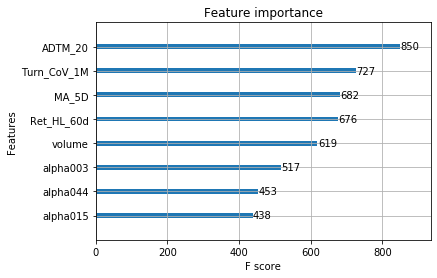

In [18]:
plot_importance(xg_reg)
plt.show() 

In [ ]:
xgboost = pd.DataFrame(out_of_sample.iloc[:,:2],columns = ["dateTime","securityId"])
xgboost['xgboost'] = preds
xgboost.to_csv("xgboost_4.csv")
#xgboost